In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

## PSxG Performance

In [2]:
n_shots = 3 # number of shots per game
pG = 0.28 # prob of goal per shot
n_games = 3*38 # number of games
roll_win = 20 # rolling average window

In [3]:
sim_num = 10000
sim_ps = []
means_ps = []
for i in range(sim_num):
    ps = np.random.binomial(n_shots,pG,n_games)
    ps = pd.DataFrame({'goals':ps})
    ps['diff'] = (n_shots*pG) - ps['goals']
    ps['mean_goals'] = ps['goals'].rolling(roll_win).mean()
    ps['roll_diff'] = (n_shots*pG) - ps['mean_goals']
    ps['per'] = (ps['roll_diff']/(n_shots*pG))*100
    
    sim_ps.append(ps)
    means_ps.append(ps['per'].mean())

Hand-picking an example to make a point. The second sim shows how an average goalkeeper can go on an underperforming (according to 20 match rolling average) streak of around 60 matches!

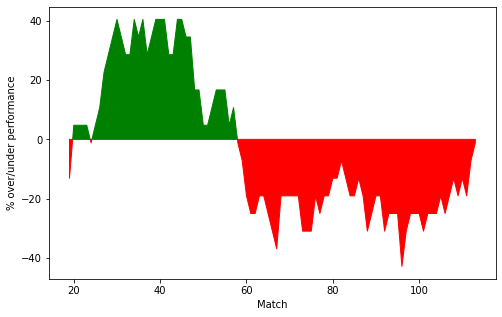

In [19]:
match = 1
fig,ax = plt.subplots(figsize=(8,5))
ax.fill_between(sim_ps[match].index,sim_ps[match]['per'],where=sim_ps[match]['per']<0,interpolate=True,color='red')
ax.fill_between(sim_ps[match].index,sim_ps[match]['per'],where=sim_ps[match]['per']>=0,interpolate=True,color='green')
ax.set_xlabel('Match')
ax.set_ylabel('% over/under performance')
plt.show()

We see the raw differences (without rolling average) are very noisy.

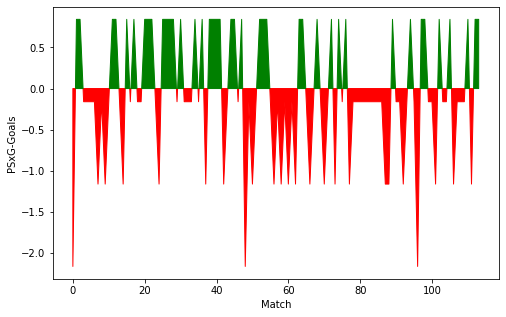

In [21]:
match = 1
fig,ax = plt.subplots(figsize=(8,5))
ax.fill_between(sim_ps[match].index,sim_ps[match]['diff'],where=sim_ps[match]['diff']<0,interpolate=True,color='red')
ax.fill_between(sim_ps[match].index,sim_ps[match]['diff'],where=sim_ps[match]['diff']>=0,interpolate=True,color='green')
ax.set_xlabel('Match')
ax.set_ylabel('PSxG-Goals')
plt.show()

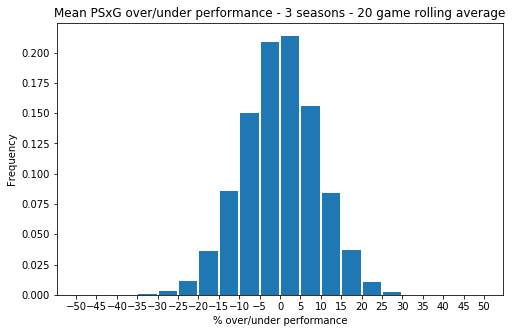

In [22]:
bins = np.arange(-50,55,5)
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(means_ps,bins=bins,weights=np.ones(len(means_ps))/len(means_ps),align='mid',rwidth=0.9)
ax.set_xticks(bins)
ax.set_xlabel('% over/under performance')
ax.set_ylabel('Frequency')
ax.set_title('Mean PSxG over/under performance - 3 seasons - 20 game rolling average')
plt.show()

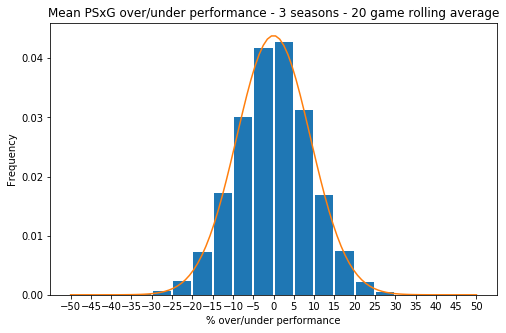

In [23]:
bins = np.arange(-50,55,5)
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(means_ps,bins=bins,density=True,align='mid',rwidth=0.9)
x = np.linspace(-50,50,100)
ax.plot(x,stats.norm.pdf(x,0,np.std(means_ps)))
ax.set_xticks(bins)
ax.set_xlabel('% over/under performance')
ax.set_ylabel('Frequency')
ax.set_title('Mean PSxG over/under performance - 3 seasons - 20 game rolling average')
plt.show()

In [28]:
len(np.array(means_ps)[np.array(means_ps) <= -5])/len(np.array(means_ps))

0.2875

Over a 3 season period, we see that the average over/under performance in PSxG is normally distributed about approximately 0. But this means, an average goalkeeper over a 3 season period could underperform (according to the mean of the 20 game rolling average) by 5% or more ~29% of the time.

When looking at the number of matches in which an average GK would underperform, however, we see that the GK actually underperforms in the majority of matches over 3 seasons (not using the 20 match rolling average).

In [31]:
perf_ratio = []
for i in sim_ps:
    perf_ratio.append(len(i[i['diff'] < 0])/len(i))

In [32]:
perf_ratio = np.array(perf_ratio)*100

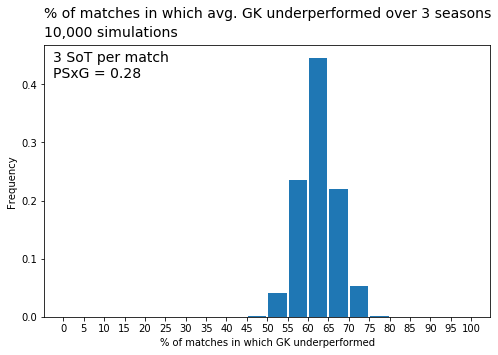

In [33]:
bins = np.arange(0,105,5)
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(perf_ratio,bins=bins,weights=np.ones(len(perf_ratio))/len(perf_ratio),align='mid',rwidth=0.9)
ax.set_xticks(bins)
ax.set_xlabel('% of matches in which GK underperformed')
ax.set_ylabel('Frequency')
ax.text(0,1.1,'% of matches in which avg. GK underperformed over 3 seasons',transform=ax.transAxes,fontsize=14)
ax.text(0,1.03,'10,000 simulations',transform=ax.transAxes,fontsize=14)
ax.text(0.02,0.88,'3 SoT per match\nPSxG = 0.28',transform=ax.transAxes,fontsize=14)
plt.show()

I believe you can make sense of this by considering that 3 SoT per match x 0.28 PSxG per shot = 0.84 PSxG total per match. Conceding 0 goals gives a decent overperformance of 0.84. But conceding 1 goal gives a slight underperformance of 0.84-1 = -0.16. This imbalance, along with the fact there are many more scorelines that give an underperformance than overperformance, means there are more matches in which a GK underperforms but actual level of over/under performance takes the normal distribution shown above. I am intrigued how this changes with number of SoT per match and the PSxG of each shot.

Let's look at the distribution of over/under performance values per match (with the 20 game rolling average).

In [34]:
all_matches = np.concatenate([i['per'].dropna().values for i in sim_ps])

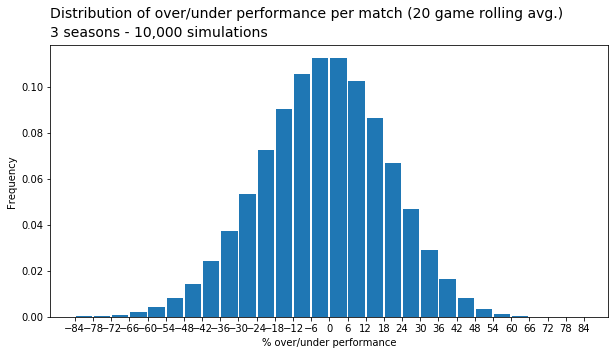

In [44]:
bins = np.arange(-84,90,6)
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(all_matches,bins=bins,weights=np.ones(len(all_matches))/len(all_matches),align='mid',rwidth=0.9)
ax.set_xticks(bins)
ax.set_xlabel('% over/under performance')
ax.set_ylabel('Frequency')
ax.text(0,1.1,'Distribution of over/under performance per match (20 game rolling avg.)',
        transform=ax.transAxes,fontsize=14)
ax.text(0,1.03,'3 seasons - 10,000 simulations',
        transform=ax.transAxes,fontsize=14)
plt.show()

Again, a normal distribution about 0.

In [179]:
def under_window(df):
    window = []
    for i in range(1,len(df)-1):
        if (np.nan_to_num(df.iloc[i-1]) >= 0) and (df.iloc[i] < 0):
            #print(i,'test')
            istart = i

        if (np.nan_to_num(df.iloc[i+1]) >= 0) and (df.iloc[i] < 0):
            #print(i+1,'test 2')
            iend = i+1
            window.append(iend - istart)
        # The case where last value is also negative and part of a window
        elif (i == (len(df)-2)) and (df.iloc[i] < 0):
            iend = i+2
            window.append(iend - istart)
        # The case where the last value is negative by itself (not part of another window)
        elif (i == (len(df)-2)) and (df.iloc[i+1] < 0):
            window.append(1)
            
    return window

In [180]:
windows_ps = []
for i in (sim_ps):
    windows_ps.append(under_window(i['per']))

In [181]:
total_windows_ps = np.array([j for i in windows_ps for j in i])

In [182]:
len(total_windows_ps)

49284

In [183]:
sum(total_windows_ps)

499291

In [65]:
np.count_nonzero(all_matches < 0)

499291

In [66]:
np.count_nonzero(all_matches > 0)

450709

In [68]:
np.count_nonzero(all_matches < 0) + np.count_nonzero(all_matches > 0)

950000

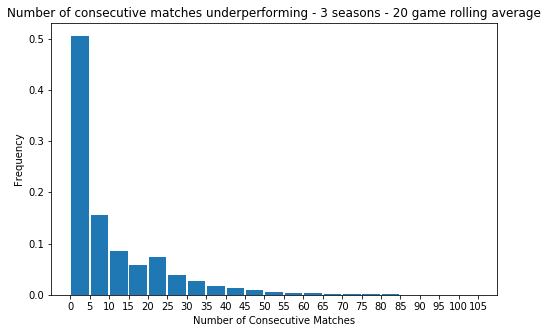

In [184]:
bins = np.arange(0,110,5)
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(total_windows_ps,bins=bins,weights=np.ones(len(total_windows_ps))/len(total_windows_ps),rwidth=0.9)
ax.set_xticks(bins)
ax.set_xlabel('Number of Consecutive Matches')
ax.set_ylabel('Frequency')
ax.set_title('Number of consecutive matches underperforming - 3 seasons - 20 game rolling average')
plt.show()

This is only the fraction of underperforming streaks, i.e. just over 50% of underperforming streaks last between 1 and 5 matches, not 50% of all streaks. For the true answer I need to compare to all matches.

In [189]:
under_frac = np.count_nonzero(all_matches < 0)/len(all_matches)
under_frac

0.5255694736842105

Underperforming matches (according to 20 game rolling average) make up ~52.3% of all matches.

In [191]:
under_streak_frac = len(total_windows_ps[total_windows_ps > 10])/len(total_windows_ps)
under_streak_frac

0.31858209560912265

Of all the underperforming streaks, ~31.9% last more than 10 games.

In [192]:
under_streak_frac * under_frac

0.16743702431449942

There is a ~16.7% chance an average GK will go on an underperforming streak of more than 10 games.

## xG performance

In [ ]:
n_shots = 5 # number of shots per game
pG = 0.12 # prob of goal per shot
n_games = 3*38 # number of games
roll_win = 20 # rolling average window

In [71]:
g_B = np.random.binomial(n_shots,pG,n_games)
g_B = pd.DataFrame({'goals':g_B})
g_B['mean_goals'] = g_B.rolling(roll_win).mean()
g_B['diff'] = g_B['mean_goals'] - (n_shots*pG)
g_B['per'] = (g_B['diff']/(n_shots*pG))*100

In [102]:
g_MC = []
for i in range(n_games):
    g = 0
    for j in range(n_shots):
        if np.random.random() <= pG:
            g += 1
    g_MC.append(g)
    
g_MC = pd.DataFrame({'goals':g_MC})
g_MC['mean_goals'] = g_MC.rolling(roll_win).mean()
g_MC['diff'] = g_MC['mean_goals'] - (n_shots*pG)
g_MC['per'] = (g_MC['diff']/(n_shots*pG))*100

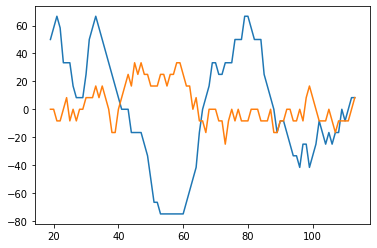

In [109]:
plt.plot(g_B['per'])
plt.plot(g_MC['per'])

In [159]:
sim_num = 10000
sim = []
means = []
for i in range(sim_num):
    g_B = np.random.binomial(n_shots,pG,n_games)
    g_B = pd.DataFrame({'goals':g_B})
    g_B['mean_goals'] = g_B.rolling(roll_win).mean()
    g_B['diff'] = g_B['mean_goals'] - (n_shots*pG)
    g_B['per'] = (g_B['diff']/(n_shots*pG))*100
    
    sim.append(g_B['per'])
    means.append(g_B['per'].mean())

In [185]:
np.nanmean(((g_B['goals'] - (n_shots*pG))/(n_shots*pG))*100)

5.263157894736846

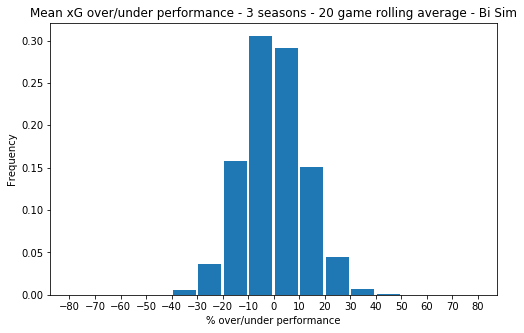

In [377]:
bins = np.arange(-80,90,10)
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(means,bins=bins,weights=np.ones(len(means))/len(means),align='mid',rwidth=0.9)
ax.set_xticks(bins)
ax.set_xlabel('% over/under performance')
ax.set_ylabel('Frequency')
ax.set_title('Mean xG over/under performance - 3 seasons - 20 game rolling average - Bi Sim')
plt.show()

In [374]:
sim_num = 10000
sim_MC = []
means_MC = []
for i in range(sim_num):
    g_MC = []
    for i in range(n_games):
        g = 0
        for j in range(n_shots):
            if np.random.random() <= pG:
                g += 1
        g_MC.append(g)
    
    g_MC = pd.DataFrame({'goals':g_MC})
    g_MC['mean_goals'] = g_MC.rolling(roll_win).mean()
    g_MC['diff'] = g_MC['mean_goals'] - (n_shots*pG)
    g_MC['per'] = (g_MC['diff']/(n_shots*pG))*100
    
    sim_MC.append(g_MC['per'])
    means_MC.append(g_MC['per'].mean())

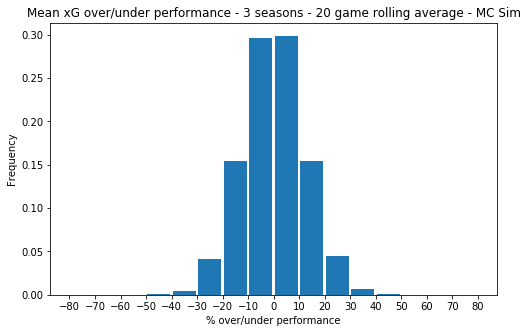

In [376]:
bins = np.arange(-80,90,10)
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(means_MC,bins=bins,weights=np.ones(len(means_MC))/len(means_MC),align='mid',rwidth=0.9)
ax.set_xticks(bins)
ax.set_xlabel('% over/under performance')
ax.set_ylabel('Frequency')
ax.set_title('Mean xG over/under performance - 3 seasons - 20 game rolling average - MC Sim')
plt.show()

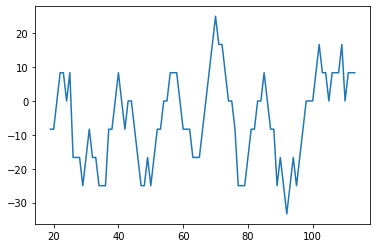

In [378]:
plt.plot(sim[0])

In [361]:
windows = []
for i in (sim):
    windows.append(under_window(i))

In [362]:
total_windows = np.array([j for i in windows for j in i])

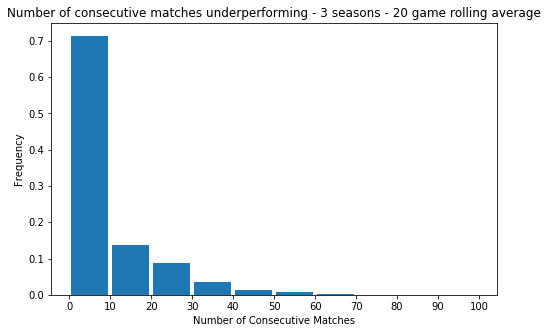

In [373]:
bins = np.arange(0,110,10)
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(total_windows,bins=bins,weights=np.ones(len(total_windows))/len(total_windows),rwidth=0.9)
ax.set_xticks(bins)
ax.set_xlabel('Number of Consecutive Matches')
ax.set_ylabel('Frequency')
ax.set_title('Number of consecutive matches underperforming - 3 seasons - 20 game rolling average')
plt.show()

## Variance

In [423]:
a = [0.1,0.1,0.2,0.2,0.2,0.3,0.3,0.4,0.4]
b = [0.1,0.1,0.1,0.1,0.2,0.2,0.2,0.3,0.3]

In [424]:
print(np.mean(a))
print(np.mean(b))

0.24444444444444446
0.17777777777777778


In [425]:
print(np.var(a))
print(np.var(b))

0.011358024691358026
0.006172839506172839


In [301]:
sim[0] >= 0

0      False
1      False
2      False
3      False
4      False
       ...  
109     True
110     True
111     True
112     True
113     True
Name: per, Length: 114, dtype: bool

In [227]:
df = sim[0] < 0

In [264]:
df.values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [244]:
b = df.cumsum()

In [261]:
b.values

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  2,  2,  2,  2,  2,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12, 13, 14, 15, 15, 15, 15, 16, 16, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 25, 25, 25, 25, 25, 25, 26, 27, 28, 29, 30, 31, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 33, 34, 35, 36, 37, 38, 39, 39, 39,
       39, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50])

In [272]:
b.mask(df).values

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., nan, nan,  2.,  2.,  2.,  2.,  2.,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       15., 15., 15., nan, 16., 16., nan, nan, nan, nan, nan, nan, nan,
       nan, nan, 25., 25., 25., 25., 25., 25., nan, nan, nan, nan, nan,
       nan, nan, 32., 32., 32., 32., 32., 32., 32., 32., 32., nan, nan,
       nan, nan, nan, nan, nan, 39., 39., 39., 39., nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50.])

In [276]:
b.mask(df).fillna(method='ffill').values

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
       15., 15., 15., 15., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32.,
       32., 32., 32., 32., 32., 39., 39., 39., 39., 39., 39., 39., 39.,
       39., 39., 39., 39., 39., 39., 39., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50.])

In [281]:
b.sub(b.mask(df).fillna(method='ffill')).values

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,
        1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
        8.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  4.,  5.,
        6.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,
        3.,  4.,  5.,  6.,  7.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  4.,
        5.,  6.,  7.,  8.,  9., 10., 11.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [192]:
data = [[1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [3, 3], [4, 4], [4, 4],
        [4, 4], [5, 5], [5, 5]]
df = pd.DataFrame(data, columns=['A', 'B'])

In [194]:
df_matching = df[df.A == df.B]

In [197]:
gb = df_matching.groupby((df_matching.A != df_matching.A.shift()).cumsum())

In [213]:
gb.filter(lambda x: len(x) >= 3)

,A,B
2,2,2
3,2,2
4,2,2
6,4,4
7,4,4
8,4,4


In [208]:
(df_matching.A != df_matching.A.shift()).cumsum()

0     1
1     1
2     2
3     2
4     2
5     3
6     4
7     4
8     4
9     5
10    5
Name: A, dtype: int64

In [201]:
df.A

0     1
1     1
2     2
3     2
4     2
5     3
6     4
7     4
8     4
9     5
10    5
Name: A, dtype: int64

In [207]:
df.A != df.A.shift()

0      True
1     False
2      True
3     False
4     False
5      True
6      True
7     False
8     False
9      True
10    False
Name: A, dtype: bool

In [ ]:
g_MC = []
for i in range(n_games):
    g = 0
    for j in range(n_shots):
        if np.random.random() <= pG:
            g += 1
    g_MC.append(g)
    
g_MC = pd.DataFrame({'goals':g_MC})
g_MC['mean_goals'] = g_MC.rolling(roll_win).mean()
g_MC['diff'] = g_MC['mean_goals'] - (n_shots*pG)
g_MC['per'] = (g_MC['diff']/(n_shots*pG))*100